## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt


fish = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
token = fish["Email Text"].str.split()
print(fish.head())
print(token.head())

   index  Unnamed: 0                                         Email Text  \
0      0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1      1           1  the other side of * galicismos * * galicismo *...   
2      2           2  re : equistar deal tickets are you still avail...   
3      3           3  \nHello I am your hot lil horny toy.\n    I am...   
4      4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  
0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object


### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [2]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()
a = pd.DataFrame(token_freq,columns=['token','count'])

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

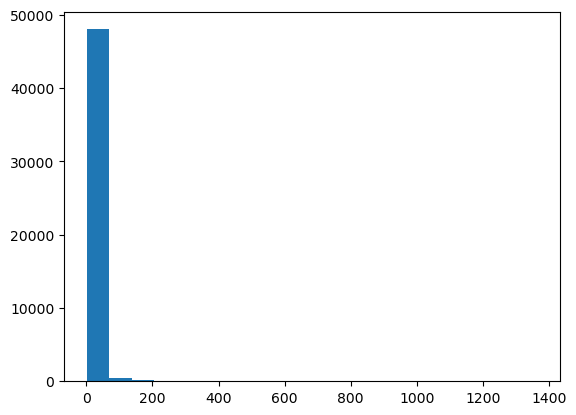

In [3]:
plt.hist(a['count'], bins=20)
plt.show()

>It looks like most words only show up a few times with a few of the words showing up a very large amount (way more than the others) as shown by the large tail close to the zero mark.

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [4]:
cleanfish = pd.read_parquet('./Phishing_clean.parquet')
y = cleanfish['Email Type']
x = cleanfish.drop('Email Type',axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=125)


regressor = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test = regressor.predict(X_test)
y_hat_train = regressor.predict(X_train)
print('train: ', r2_score(y_hat_train,y_train) )
print('test: ', r2_score(y_hat_test,y_test) )  


words = pd.DataFrame({'variable':regressor.feature_names_in_ , 'value':regressor.coef_})
words['abs'] = np.abs(words['value'])
words.sort_values('abs',ascending=False)

train:  0.6159015381792188
test:  -0.0002683843266513275


,variable,value,abs
33,2001,1.090207e+13,1.090207e+13
74,"2002,",-1.084084e+13,1.084084e+13
710,1997,-1.001920e+13,1.001920e+13
1721,"06,",9.410411e+12,9.410411e+12
1998,7.3,8.951357e+12,8.951357e+12
...,...,...,...
844,james,-1.220703e-04,1.220703e-04
1867,index,-1.187325e-04,1.187325e-04
1104,preliminary,-1.239777e-05,1.239777e-05
1618,font,5.722046e-06,5.722046e-06


### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

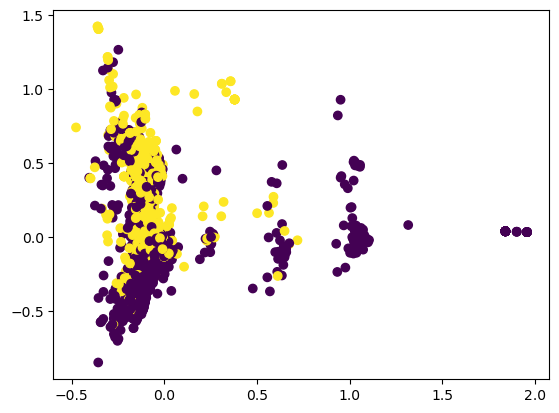

In [5]:
decomp = PCA(n_components=2).fit(X_train)
test = decomp.transform(X_test)
hue = y_test
plt.scatter(test[:,0], test[:,1], c=hue)
plt.show()

> The yellow dots are scam points which makes sense since they are more condensed on the left of the plot. 

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [7]:
decomp2 = PCA(n_components=2610).fit(X_train)
test2 = decomp2.transform(X_test)
train2 = decomp2.transform(X_train)

regressor2 = LinearRegression(fit_intercept=False).fit(train2,y_train)
y_hat_test2 = regressor2.predict(test2)
y_hat_train2 = regressor2.predict(train2)
print('train: ', r2_score(y_hat_train2,y_train) )
print('test: ', r2_score(y_hat_test2,y_test) )  


train:  -0.14805164032756313
test:  -0.1989500815072407


> This performance is much better as the test set is much closer to the train set than in our original regression which saw a much larger difference between the train and test sets.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

> The principal components allow us to have more control in the regression as we can choose how many to use as we decompose the original data set into our components. Using principal components simplifies the original data as it reduces the number of variables and allows the regressor to work more accurately. The drawbacks is that unlike the original data we were looking at, the principal components are harder to analyze as the context given by the variables lost.